In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt

In [16]:
python = pd.read_csv("./awsresults/python.csv", skipinitialspace=True)

In [3]:
java = pd.read_csv("./awsresults/java.csv")

In [5]:
java["Benchmark"] = java["Benchmark"].str.split('.').str[-1]

In [6]:
java

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit
0,alloc_full_tree,avgt,1,30,2.307176,0.036804,ms/op
1,alloc_list,avgt,1,30,839.113526,93.254986,ms/op
2,alloc_vector,avgt,1,30,26.954890,0.366312,ms/op
3,sum,avgt,1,30,4.962264,0.001494,ms/op
4,sum_list,avgt,1,30,36.539916,0.039989,ms/op
5,sum_tree,avgt,1,30,1.284832,0.027147,ms/op
6,sum_vector,avgt,1,30,9.174569,0.022747,ms/op


In [13]:
java_df = java[["Benchmark", "Score", "Score Error (99.9%)"]] \
    .rename(columns={"Benchmark": "benchmark", "Score": "time", "Score Error (99.9%)": "error"})
java_df["language"] = "java"
java_df.set_index(["benchmark", "language"], inplace=True)
java_df

,,time,error
benchmark,language,,
alloc_full_tree,java,2.307176,0.036804
alloc_list,java,839.113526,93.254986
alloc_vector,java,26.954890,0.366312
sum,java,4.962264,0.001494
sum_list,java,36.539916,0.039989
sum_tree,java,1.284832,0.027147
sum_vector,java,9.174569,0.022747


In [70]:
python = python[python["run_id"] < 100]

In [72]:
python[python["benchmark"] == "alloc_full_tree"].mean()

run_id     49.500000
time      397.319566
dtype: float64

In [83]:
#agg = python.groupby("benchmark")["time"].mean()
#pd.concat([python.groupby("benchmark")["time"].mean(), python.groupby("benchmark")["time"].std().rename("error")], axis=1)

Python has high instability on alloc_full_tree, normally it runs around 260ms, but it spikes to 2s sometimes.
For now I ignor these outliers, but we could plot them in details (although we don't have such data for JVM)

In [79]:
agg = python.groupby("benchmark")["time"]
pydf = pd.DataFrame({"low": agg.median() - agg.quantile(0.1), "hi": agg.quantile(0.9) - agg.median()})
err = pydf[["low", "hi"]].max(axis=1)
pydf = pd.DataFrame({"time": agg.median(), "error": err, "language": "python"})
pydf = pydf.reset_index().set_index(["benchmark", "language"])
pydf

,,time,error
benchmark,language,,
100ms,python,100.214947,0.003729
alloc_full_tree,python,267.233709,1.620339
alloc_list,python,15453.796573,1795.286100
alloc_vector,python,612.366446,1.968831
sum,python,878.030706,2.351081
sum_list,python,960.918656,0.397923
sum_tree,python,87.455905,0.131699
sum_vector,python,433.351415,0.268838


In [80]:
cmp = pd.concat([pydf, java_df]).reset_index()
cmp

,benchmark,language,time,error
0,100ms,python,100.214947,0.003729
1,alloc_full_tree,python,267.233709,1.620339
2,alloc_list,python,15453.796573,1795.286100
3,alloc_vector,python,612.366446,1.968831
4,sum,python,878.030706,2.351081
5,sum_list,python,960.918656,0.397923
6,sum_tree,python,87.455905,0.131699
7,sum_vector,python,433.351415,0.268838
8,alloc_full_tree,java,2.307176,0.036804
9,alloc_list,java,839.113526,93.254986


         benchmark language        time     error
1  alloc_full_tree   python  267.233709  1.620339
8  alloc_full_tree     java    2.307176  0.036804


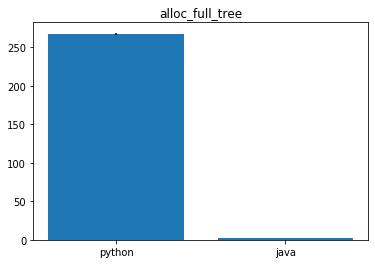

    benchmark language          time        error
2  alloc_list   python  15453.796573  1795.286100
9  alloc_list     java    839.113526    93.254986


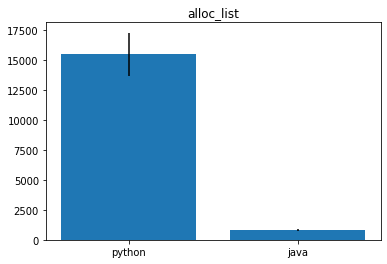

       benchmark language        time     error
3   alloc_vector   python  612.366446  1.968831
10  alloc_vector     java   26.954890  0.366312


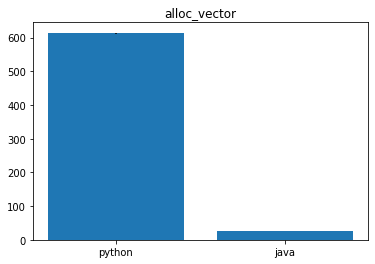

   benchmark language        time     error
4        sum   python  878.030706  2.351081
11       sum     java    4.962264  0.001494


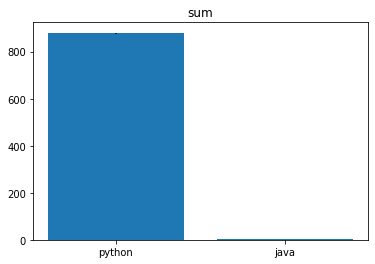

   benchmark language        time     error
5   sum_list   python  960.918656  0.397923
12  sum_list     java   36.539916  0.039989


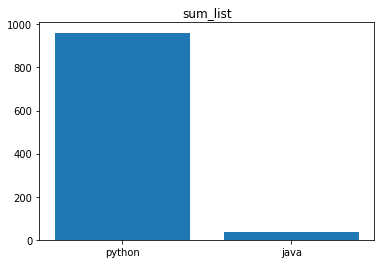

   benchmark language       time     error
6   sum_tree   python  87.455905  0.131699
13  sum_tree     java   1.284832  0.027147


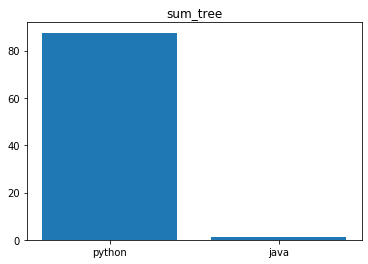

     benchmark language        time     error
7   sum_vector   python  433.351415  0.268838
14  sum_vector     java    9.174569  0.022747


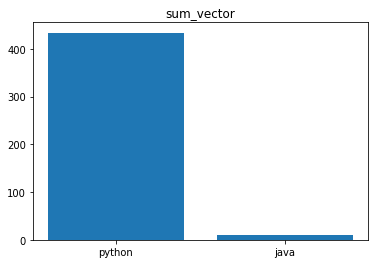

In [84]:
for b in cmp["benchmark"].unique():
    if b == "100ms":
        continue
    part = cmp[cmp["benchmark"] == b]
    print(part)
    plt.bar(x=part["language"], height=part["time"], yerr=part["error"])
    plt.title(b)
    plt.show()

## Information regarding the benchmarks

The basic code is at https://github.com/enso-org/benchmarks/tree/wip/rw/initial-microbenchmarks

For now I have skipped JS and C++ as I don't have a good methodology there. C++ would be doable with some framework, but due to time constraints I couldn't make it. We still compare with Java and C++'s performance on this kind of code should be more-or-less comparable (but of course we should do a good comparison when time allows).

While trying to benchmark Enso, I first was running it in Enso a'la https://github.com/enso-org/enso/tree/main/test/Benchmarks
However as this incurred running different benchmarks in the same JVM and issues with sharing the state of JIT, I tried to repurpose the JMH benchmarks from `runtime` project, that can be found at https://github.com/enso-org/enso/compare/wip/rw/jmh-experiment

So after all I compare Java and Enso using JMH, both are written in a very similar way. They use `avgt` mode which computes average time in milliseconds for operation.

For Python, I run many iterations saving time of each and compute medians (alternatively means) of the timings.